# Diploma XXX

## Setup

### import necesery liblaries

In [70]:
import torch
import wandb
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from tinyai.imports import *

### Config


In this configuration, we are setting up various parameters and options for our workflow.

- Setting the precision, linewidth, and scientific notation mode for printing tensors.
- Setting the random seed for reproducibility.
- Configuring the color map and DPI for matplotlib figures.
- Setting the random seed and limiting the number of CPUs used. These configurations ensure consistent and optimized behavior throughout the workflow.


In [71]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 100

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

### Loading in FashionMNIST dataset the dataset and preparing the data for later use

In [ ]:
# Load the FashionMNIST dataset from Hugging Face
dataset = load_dataset('fashion_mnist')
bs=512*4
epochs = 5
lr = 2e-2
dataset

Lets see the image

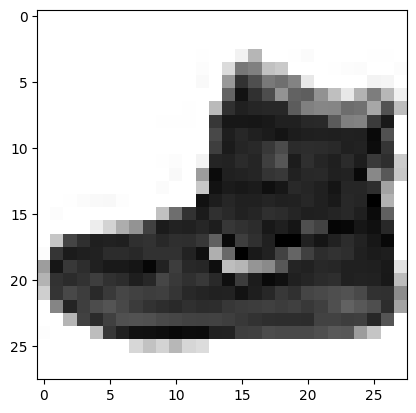

In [73]:
image = dataset['train'][0]['image']
plt.imshow(image);

Transforming a PIL image to a Tensor is necessary  because it allows us to perform various operations on the image using PyTorch.

- PyTorch works with tensors as the primary data structure for representing and manipulating data.
- We can leverage GPUs for accelerated computation. Tensors can be easily moved to and processed on GPUs, enabling faster training and inference.

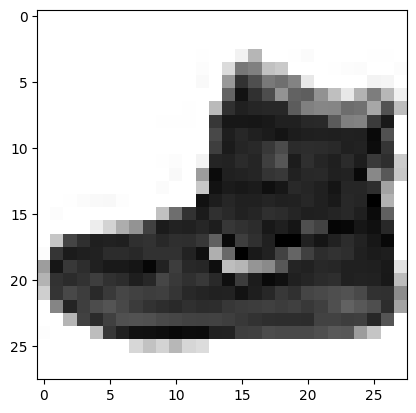

In [74]:
plt.imshow(transforms.ToTensor()(image)[0]);

Lets create a function that will this to whole dataset

In [75]:
@inplace
def transformi(b): b['image'] = [transforms.ToTensor()(o) for o in b['image']]

In [76]:
dataset = dataset.with_transform(transformi)
image = dataset['train'][0]['image']
image.shape

torch.Size([1, 28, 28])

In [77]:
dls = DataLoaders.from_dd(dataset,batch_size=bs)

next(iter(dls.train))[0].shape

torch.Size([2048, 1, 28, 28])

#  Baseline model

####  Exaplin what ResBlock is doing
```python
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks // 2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res
    
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))
```

In [78]:
def get_model(act=nn.ReLU,norm=False):
    layers = [ResBlock(1, 16, stride=1, act=act, norm=norm),
              # Why we stride 2 here? Because we want to reduce the size of the image by half
              ResBlock(16, 32, stride=2, act=act, norm=norm),
              ResBlock(32, 64, stride=2, act=act, norm=norm),
              ResBlock(64, 128, stride=2, act=act, norm=norm),
              ResBlock(128, 256, stride=2, act=act, norm=norm),
              ResBlock(256, 512, stride=2, act=act, norm=norm),
              nn.Flatten(),
              nn.Linear(512, 10, bias=False),
              nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)
get_model();

In [79]:
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True),MetricsCB(), astats]
learn = TrainLearner(get_model(), dls,F.cross_entropy, lr=lr, cbs=cbs)

loss,epoch,train
1.611,0,train
2.250,0,eval
1.089,1,train
1.924,1,eval
0.950,2,train
1.128,2,eval
0.875,3,train
0.856,3,eval
0.817,4,train
1.413,4,eval


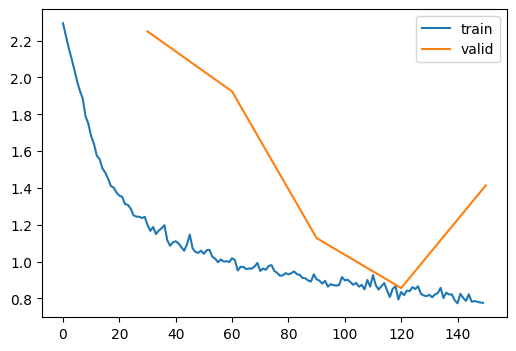

In [80]:
learn.fit(epochs)

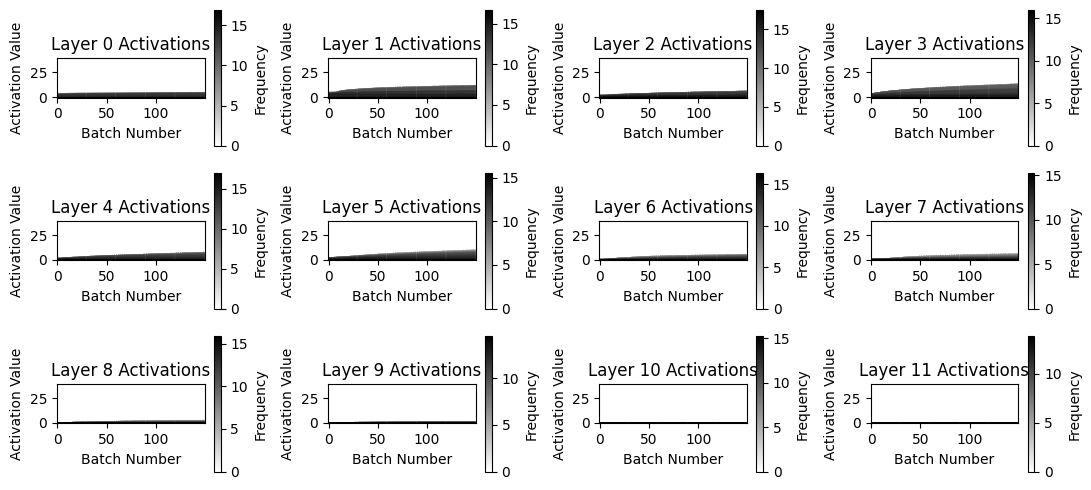

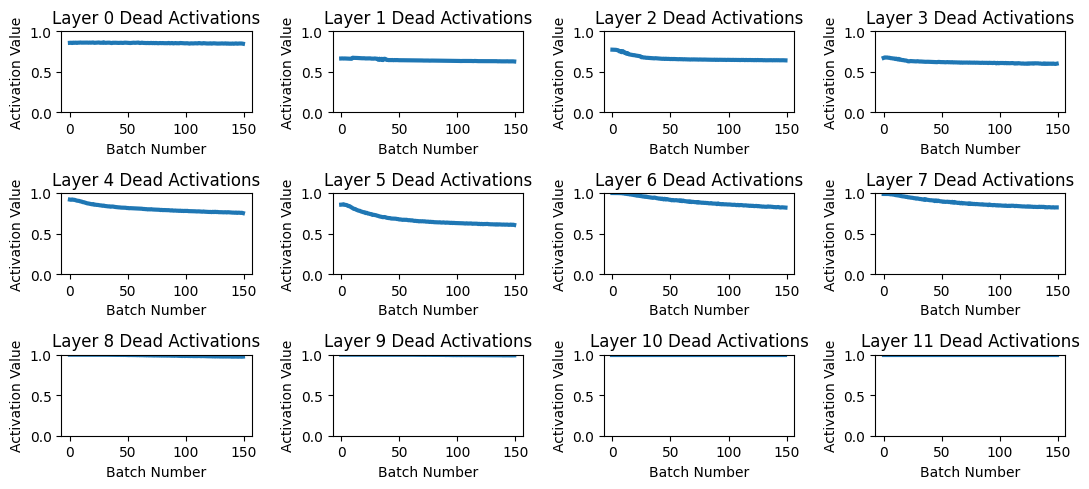

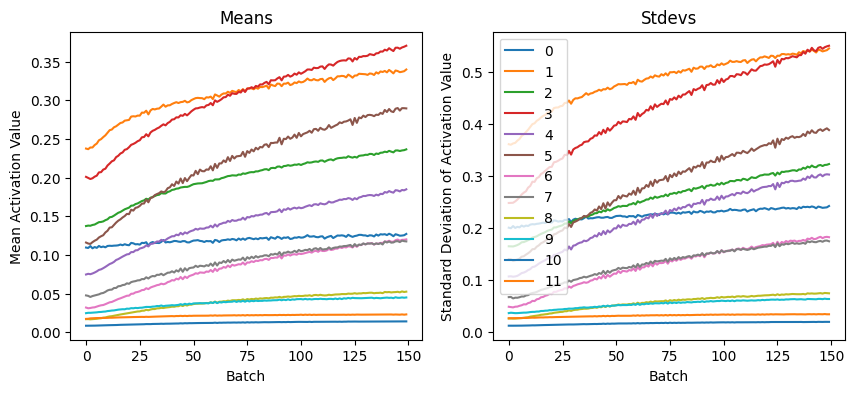

In [81]:
def print_activ():
    astats.color_dim()
    astats.dead_chart()
    astats.plot_stats()
print_activ()


# Data Normalization

Since our model is not training, it is important to normalize the data to ensure that all features are on a similar scale. This helps in improving the performance and convergence of the model during training.

To normalize the data, we can...

In [82]:
image.mean(), image.std()

(tensor(0.3814), tensor(0.3994))

In [83]:
xmean,xstd = next(iter(dls.train))[0].mean(), next(iter(dls.train))[0].std()
xmean,xstd

(tensor(0.2883), tensor(0.3539))

In [84]:
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]
tds = dataset.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
xb,yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(-0.0003), tensor(1.0010))

In [85]:
for i in range(5):
    print(xb[i].mean(), xb[i].std())

tensor(-0.3530) tensor(0.7864)
tensor(0.2976) tensor(0.9030)
tensor(-0.4686) tensor(0.5898)
tensor(0.1044) tensor(1.1804)
tensor(0.0072) tensor(1.0364)


Not every image has mean - 0, std - 1, but the whole batch is close to it and this is what mattters.\

### Lets try trainning with normalized input's

In [86]:
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True),MetricsCB(), astats]
learn = TrainLearner(get_model(), dls,F.cross_entropy, lr=lr, cbs=cbs)

loss,epoch,train
1.482,0,train
2.241,0,eval
1.031,1,train
1.882,1,eval
0.901,2,train
1.034,2,eval
0.822,3,train
0.812,3,eval
0.771,4,train
0.832,4,eval


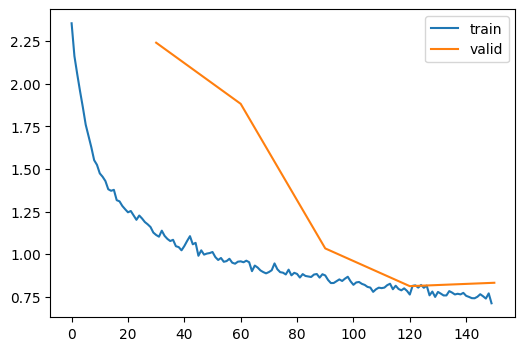

In [87]:
learn.fit(epochs)

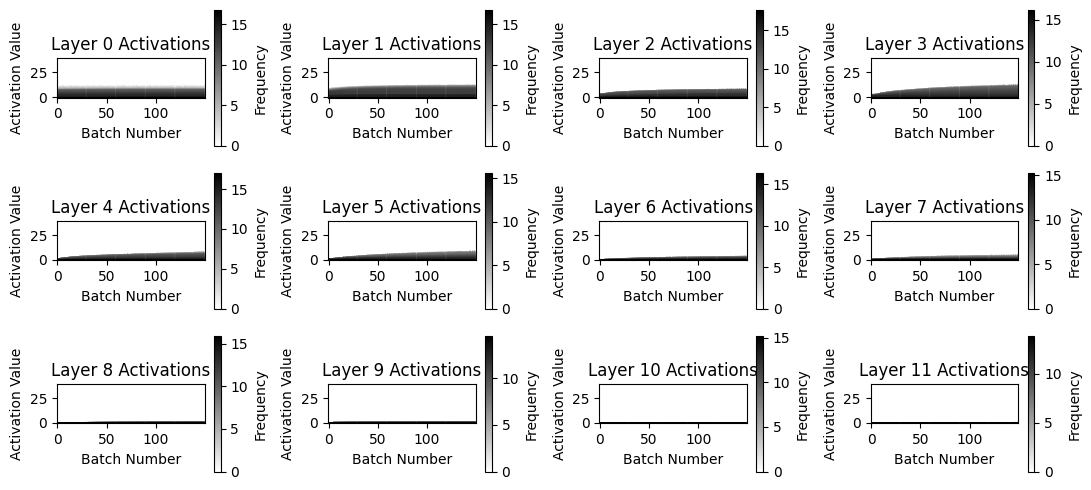

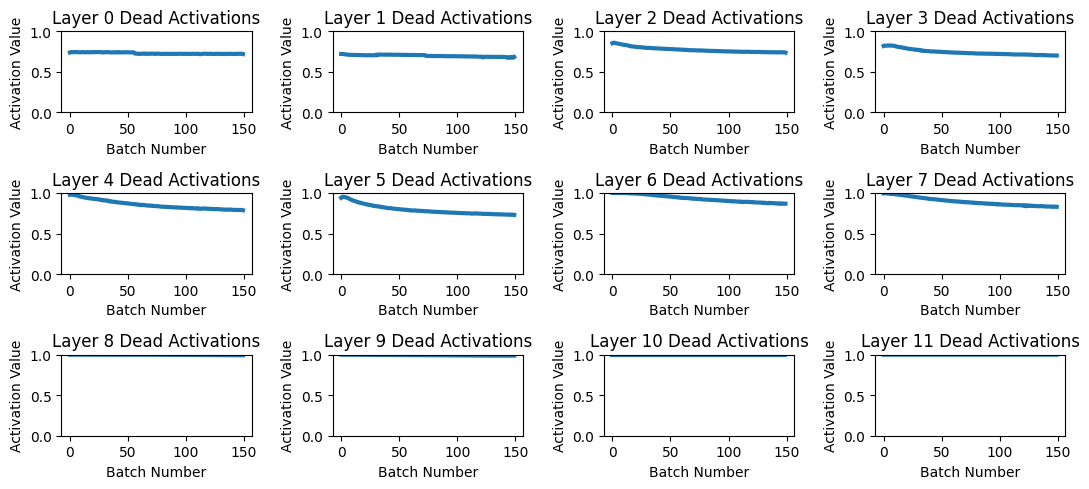

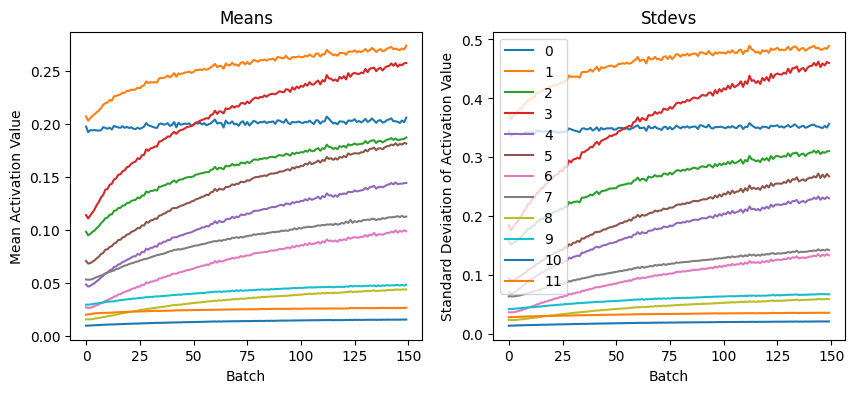

In [88]:
print_activ()

Here we can see that some of our activation are starting to move but the mean and std are still incorect. \
The reason is it dosn't matter that our input are normalized if are weight are not and after layer we lose the normalization.
The solution is to initialize our weight and not use random weights(the ones we were using before).

In [89]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [90]:
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), astats]
iw = partial(init_weights)
model = get_model().apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

loss,epoch,train
1.164,0,train
1.051,0,eval
0.807,1,train
1.083,1,eval
0.723,2,train
0.868,2,eval
0.663,3,train
0.708,3,eval
0.620,4,train
0.704,4,eval


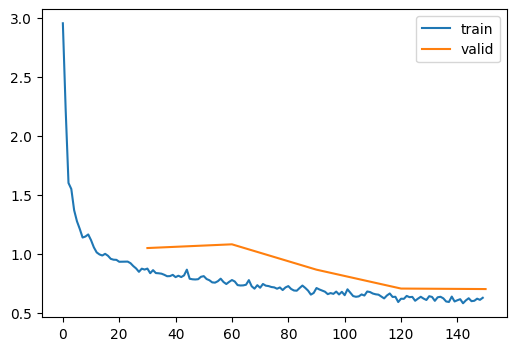

In [91]:
learn.fit(epochs)

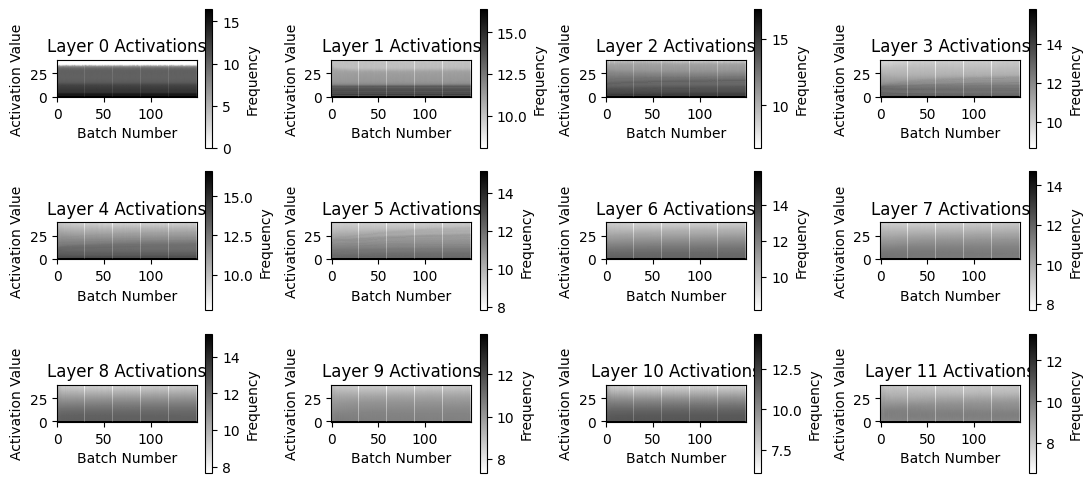

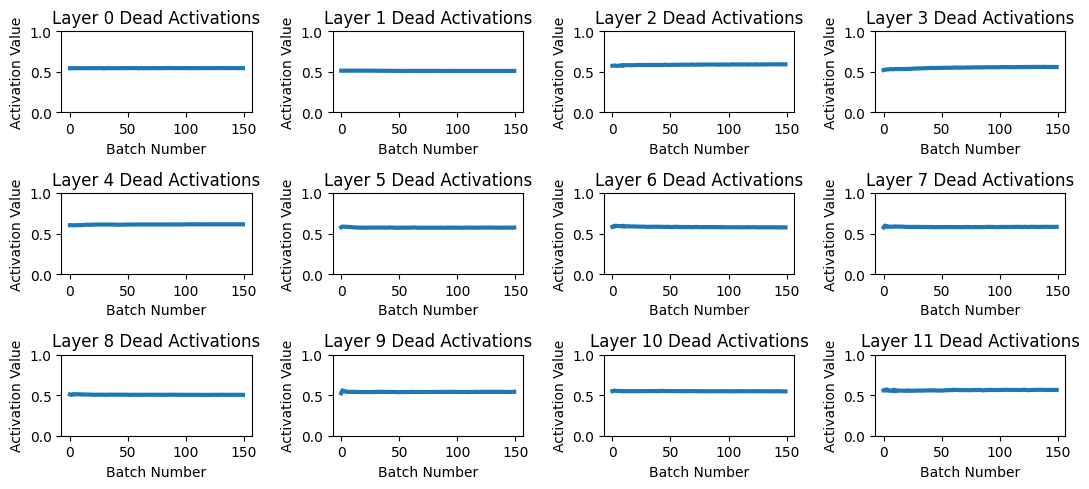

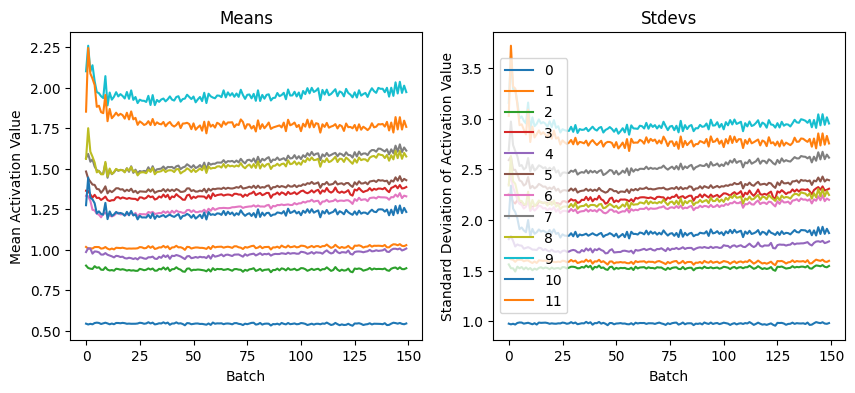

In [92]:
print_activ()

# Leaky ReLU
----


In [93]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), astats]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

loss,epoch,train
1.105,0,train
0.985,0,eval
0.791,1,train
0.807,1,eval
0.697,2,train
0.698,2,eval
0.639,3,train
0.674,3,eval
0.596,4,train
0.607,4,eval


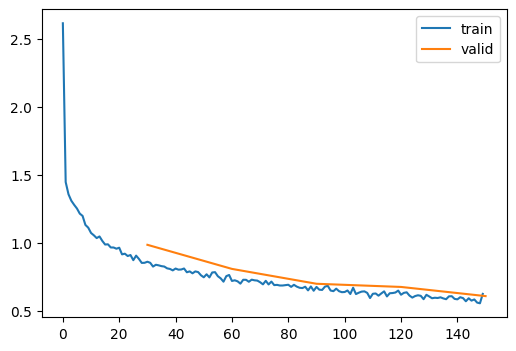

In [94]:
learn.fit(epochs)

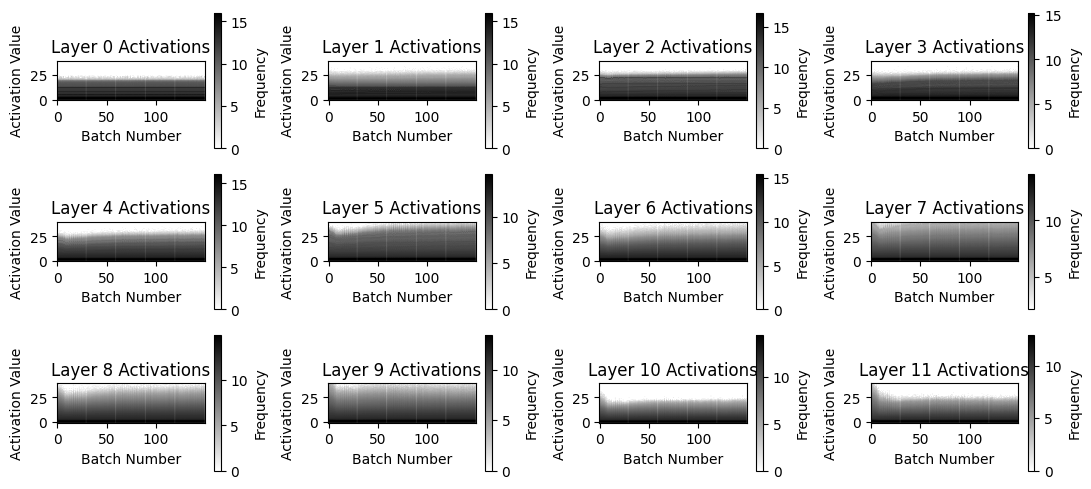

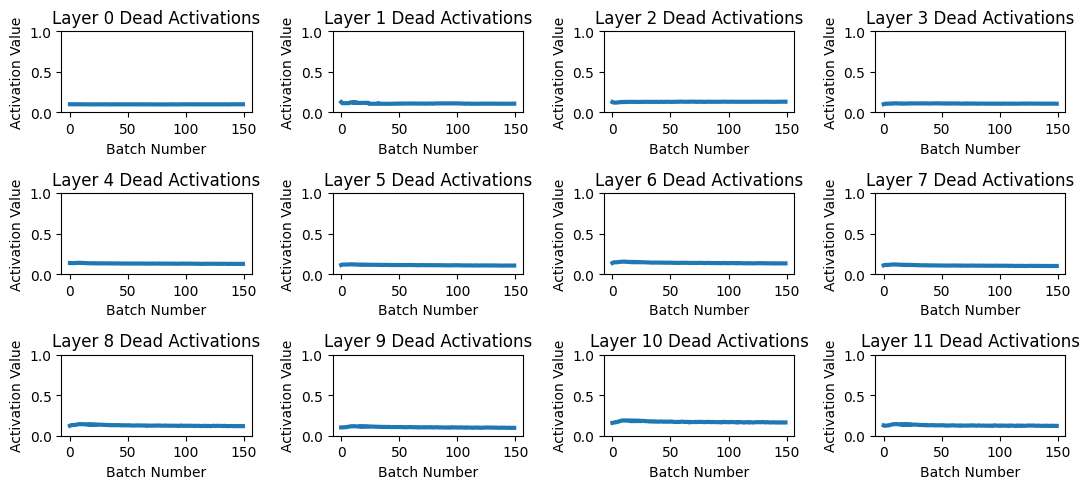

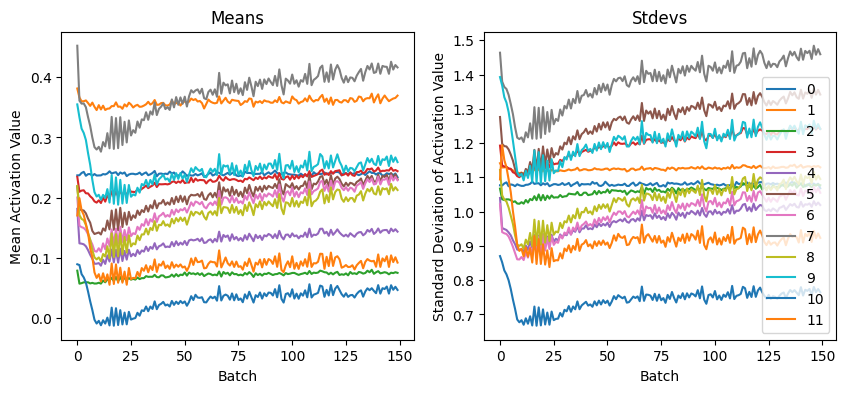

In [95]:
print_activ()

# BatchNorm
---


In [96]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), astats]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs)

loss,epoch,train
0.990,0,train
0.844,0,eval
0.728,1,train
0.705,1,eval
0.649,2,train
0.644,2,eval
0.596,3,train
0.598,3,eval
0.555,4,train
0.567,4,eval


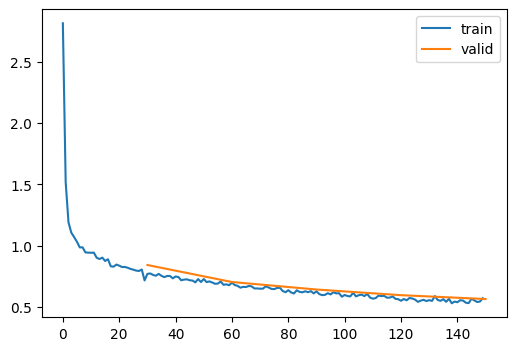

In [97]:
learn.fit(epochs)

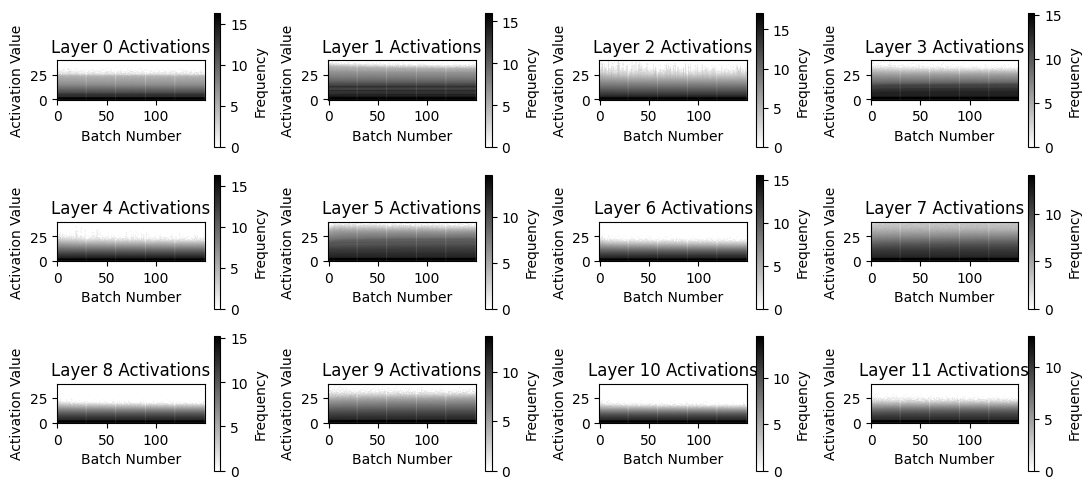

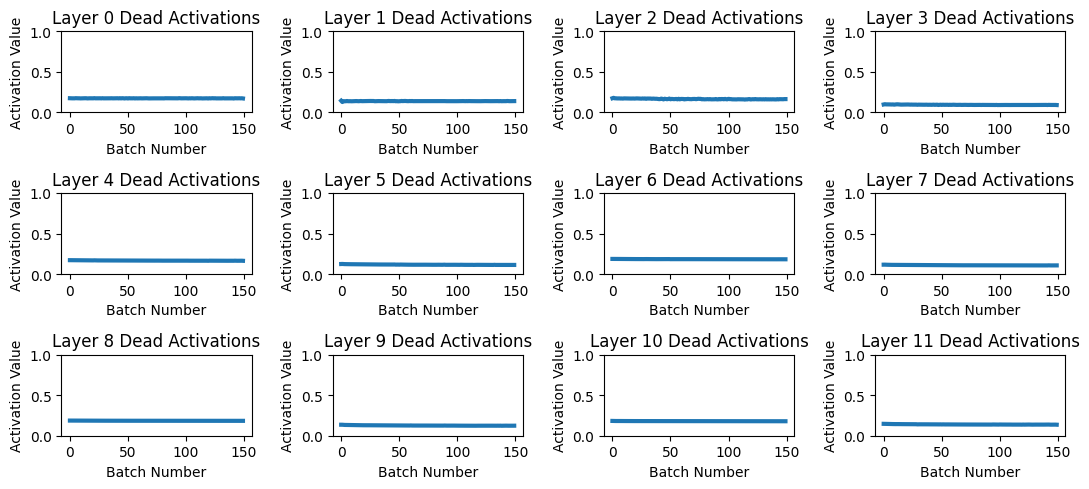

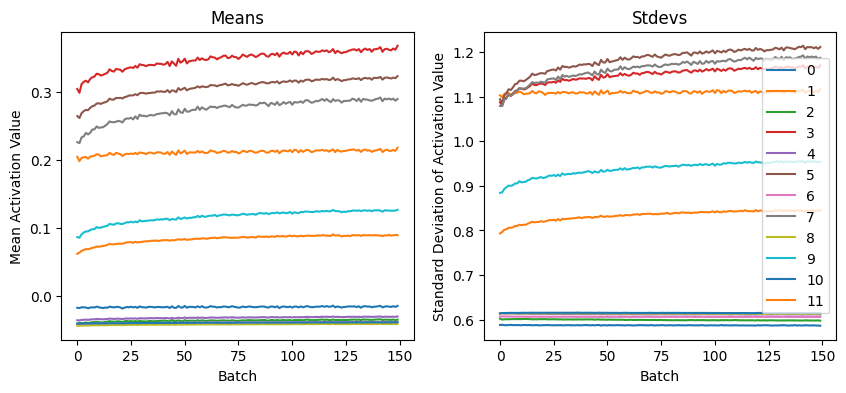

In [98]:
print_activ()

# LR-sched

In [99]:
def _lr(cb): return cb.pg['lr']
record = RecorderCB(lr = _lr)

In [100]:
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=0.2, total_steps=tmax)

astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), astats]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra)

loss,epoch,train
0.912,0,train
0.691,0,eval
0.340,1,train
0.391,1,eval
0.260,2,train
0.311,2,eval
0.216,3,train
0.280,3,eval
0.178,4,train
0.249,4,eval


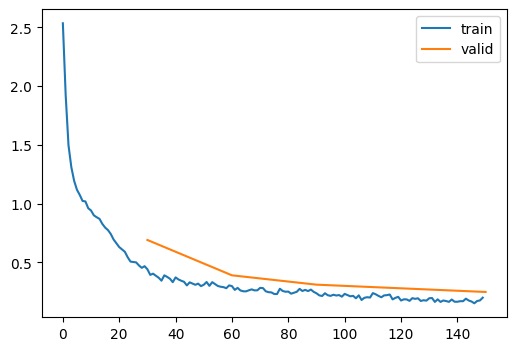

In [101]:
learn.fit(epochs)

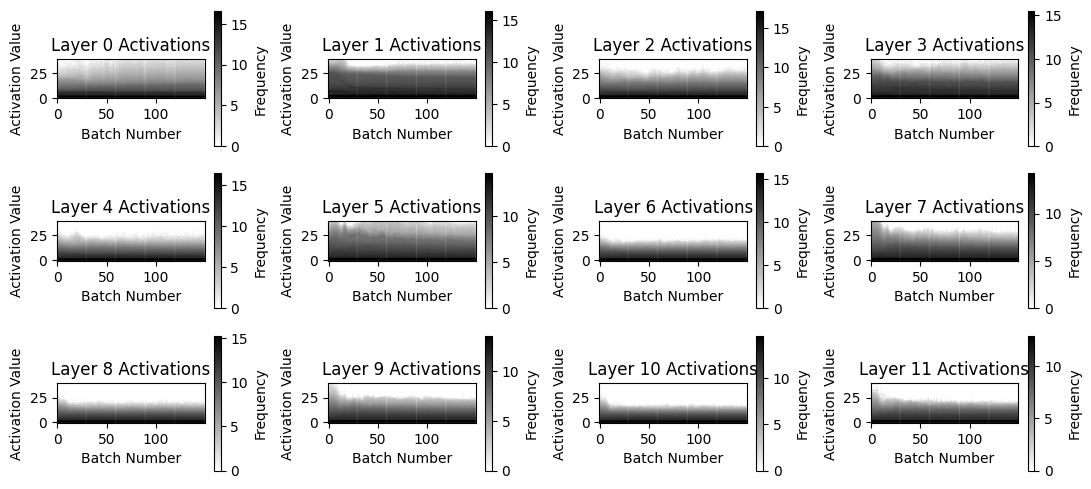

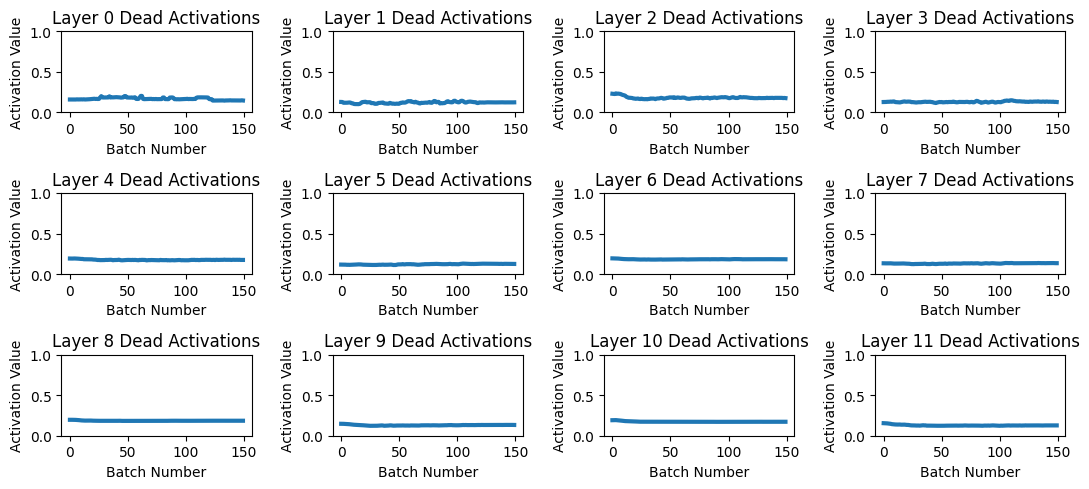

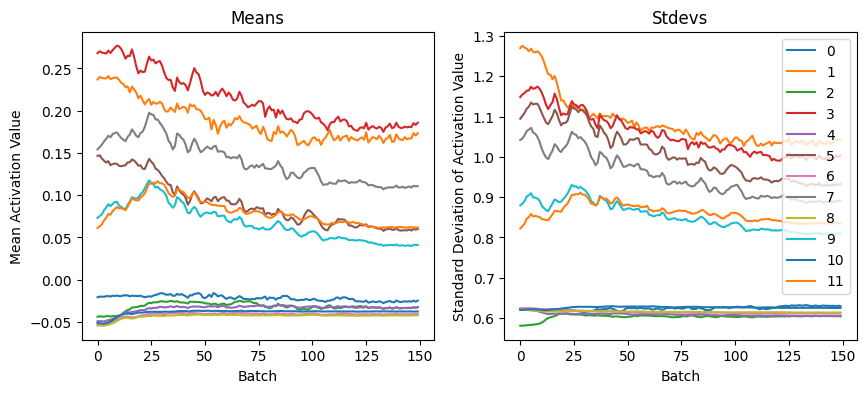

In [102]:
print_activ()

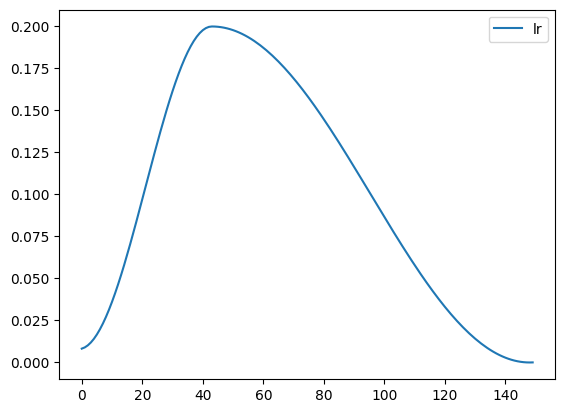

In [103]:
record.plot()

# AdamW

In [104]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
record = RecorderCB(lr = _lr, mom = _beta1)

In [105]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), astats]
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
model = get_model(act_gr,norm=nn.BatchNorm2d).apply(iw)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

loss,epoch,train
0.797,0,train
0.763,0,eval
0.414,1,train
0.433,1,eval
0.275,2,train
0.343,2,eval
0.208,3,train
0.245,3,eval
0.161,4,train
0.223,4,eval


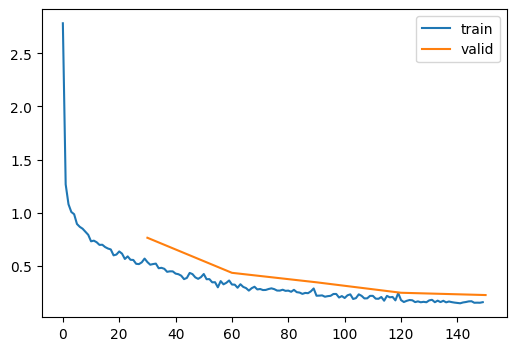

In [106]:
learn.fit(epochs)

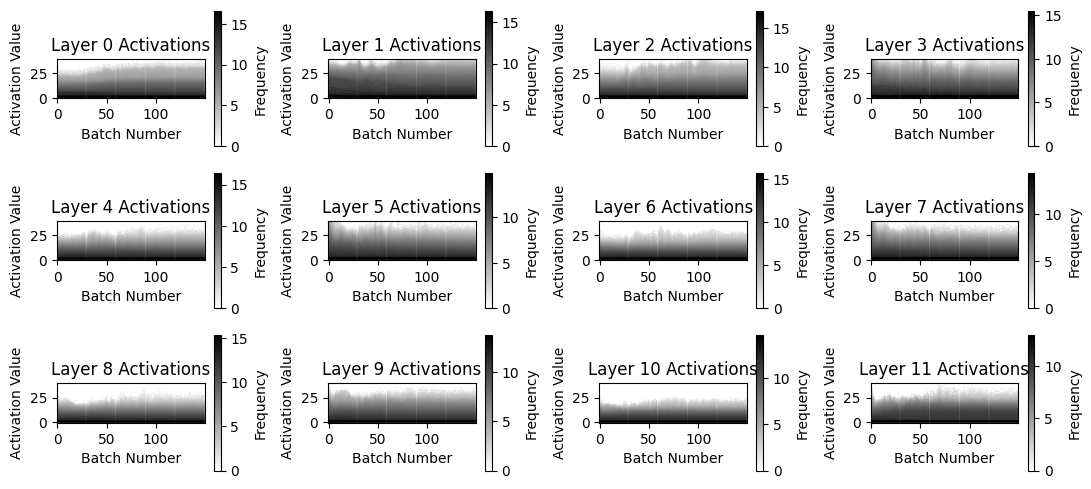

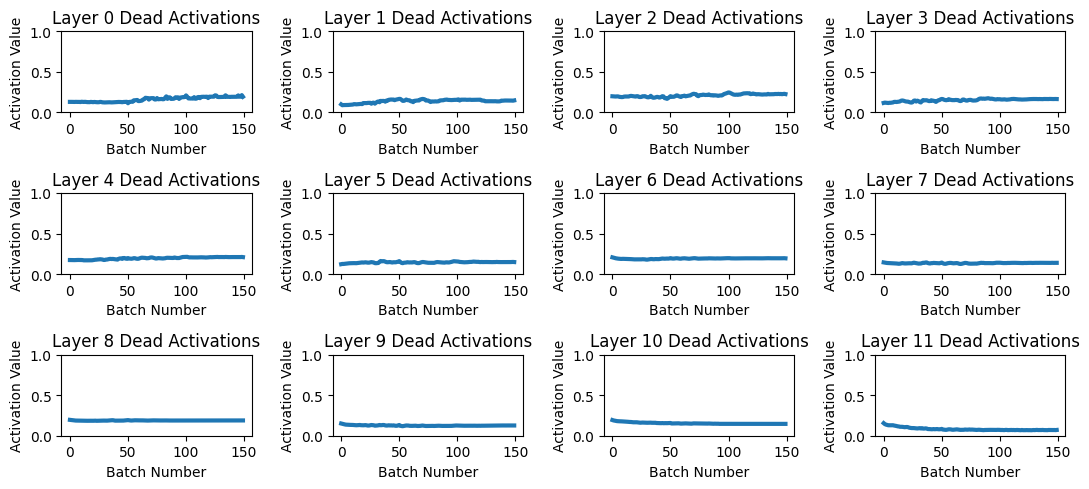

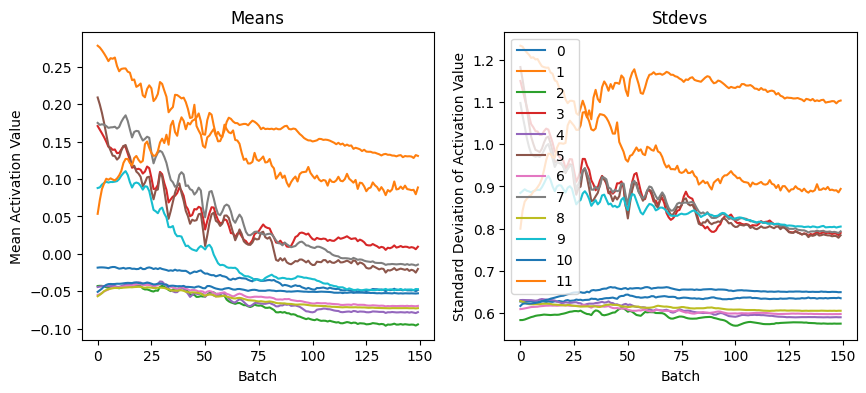

In [107]:
print_activ()

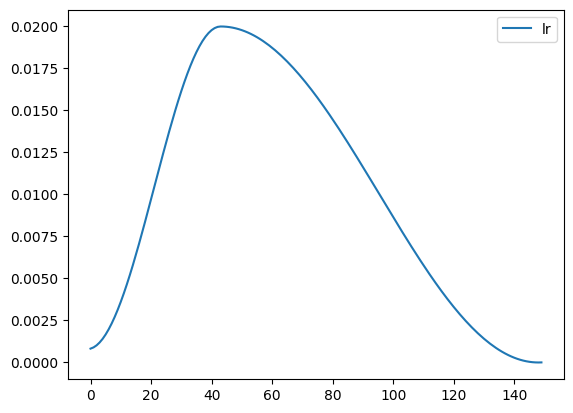

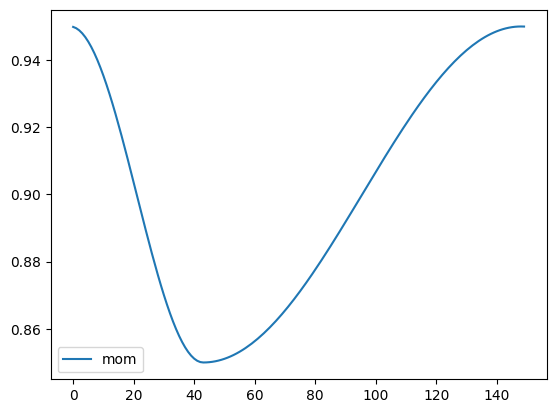

In [108]:
record.plot()

# Aug

In [109]:
#@inplace
#def transformi(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]